# KNN Optimization - Programming Machine Learning Algorithms on HPC
Authors:
- Giorgio Daneri
- Daniele Ferrario
- Luca Guffanti

## Section 1 - MPI-Based Parallelization
The `mpi4py` python package was employed to transparently distribute computation between nodes. Efforts were put into subdividing the training set as evenly as possible between the available ranks, with rank $0$ generating the set and coordinating the distribution. Each rank $r$ has access to a number of rows $n$ where

$n =\begin{cases}
\mathrm{training\ size} / \mathrm{MPI\ size} + 1\qquad \text{if } r< \mathrm{training\ size} \mod(\mathrm{MPI\ SIZE})\\ 
\mathrm{training\ size} / \mathrm{MPI\ size} \qquad\quad\ \ \  \text{otherwise}\end{cases}$ 

The parallelization proceeded as follows: it was noted that the program presented two bottlenecks, solvable with parallelization, which were the heavy euclidean distance computation as well as the final sorting of the computed distances. Thus, the training
data set is __scattered__ (non homogenously) to all mpi ranks following the previous formula. The training dataset, which is notably smaller, is instead broadcast to all processes before the start of the actual prediction. Then, the algorithm proceeds in the following way


For each prediction
1. Each rank $r$ independently computes the list of euclidean distances, $d_r$
2. Each rank $r$ independently extracts the $k$ indices of the minimum distances from $d_r$, generating $i_r$
3. Each rank $r$ sums its own element offset (computed through a cumulated sum of elements per row until $r$) to the set
 of indices $i_r$ in order to get the global indices of the elements in the training set
4. Each rank $r$ sends to the root rank $0$ the $i_r$ and $d_r$ lists.
5. Root rank $0$ extracts the least $k$ distances together with their related indices from the gathered lists and returns the most common label 

### Executing the code
You can execute the code either in automatic mode or in normal mode. Normal mode execution has a more verbose output.
Executing serial code can be done directly in the jupyter notebook.

In [ ]:
# Automatic Execution (on 1000*500 dataset, 1000 tests)
%run  knn_mpi/mpi/test_knn_seq.py -a

7.000460624694824


In [ ]:
# Normal Execution (on 1000*500 dataset, 1000 tests)
%run knn_mpi/mpi/test_knn_seq.py

correct 715
Time 6.9150755405426025s


However, the MPI-parallelized code cannot be executed directly in the Jupyter notebook. You find the implementation in the `ParallelKNNClassifier` class, and you should run in a shell one of following commands
```bash
    mpirun -n your_cores python ./knn_mpi/mpi/test_knn_parallel.py -a
```
or 
```bash
    mpirun -n your_cores python ./knn_mpi/mpi/test_knn_parallel.py
```
For the automatic execution and normal execution modes, respectively.

### Running the test

In order to run the tests you should carefully modify the `run_tests.sh/run_tests_slurm.sh` script based on the computational power of your testing system,
by changing the __number of cores__ , __tests sizes__ and __iterations__ that will be run. Once you are ready, run 
```bash
    ./knn_mpi/run_tests.sh
```
or
```bash
    sbatch ./knn_mpi/run_tests_slurm.sh
```
is executed,
based on whether or not you are using __SLURM__.

### Results

Tests executions produce a `.csv` result file, `mpi_res.csv`, that can be accessed by the following cells and analyzed 

In [1]:
%pip install pandas
%pip install seaborn
%pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('knn_mpi/mpi_res.csv')
df.head(5)

,proc,time
0,256,2.765805
1,256,2.862740
2,256,2.657062
3,256,3.114009
4,256,2.829576


Text(0.5, 1.0, 'KNN Prediction Time vs Number of Processes - loglog')

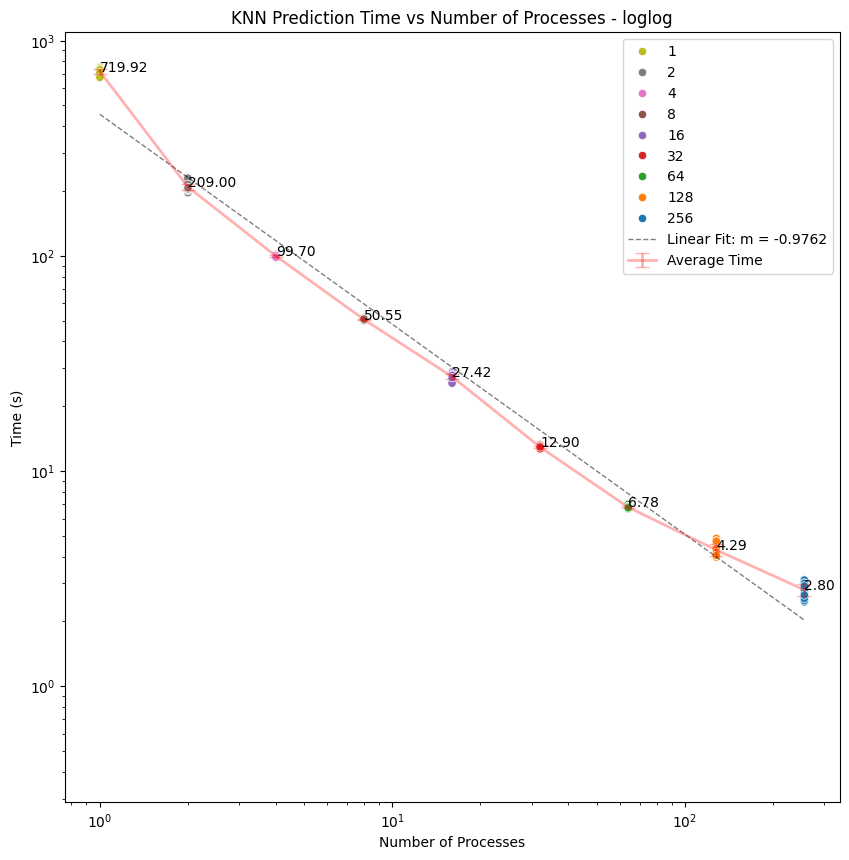

In [2]:
# Build a colormap based on the number of processes
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in np.linspace(0, 1, 10)]

df_grouped = df.groupby('proc').agg({'time': ['mean', 'std']})
proc_colors = {proc: colors[i] for i, proc in enumerate(df['proc'].unique())}

# Plot data in a scatter plot with the given colormap
plt.figure(figsize=(10, 10))
plt.yscale('log')
plt.xscale('log')
sns.scatterplot(data=df, x='proc', y='time', alpha=1, palette=proc_colors, hue='proc')

plt.errorbar(df_grouped.index, df_grouped['time']['mean'], yerr=df_grouped['time']['std'], fmt='r', label='Average Time', lw=2, alpha=0.3, capsize=5)

for i, row in df_grouped.iterrows():
    plt.text(i, row['time']['mean'], f'{row["time"]["mean"]:.2f}', ha='left', color='black', fontsize=10)


# Fit the data to a line in the log log plot
m, b = np.polyfit(np.log(df_grouped.index), np.log(df_grouped['time']['mean']), 1)
plt.plot(df_grouped.index, np.exp(m*np.log(df_grouped.index) + b), 'k--', alpha=0.5, label=f'Linear Fit: m = {m:.4f}', lw=1)

plt.legend()
plt.xlabel('Number of Processes')
plt.ylabel('Time (s)')
plt.title('KNN Prediction Time vs Number of Processes - loglog')

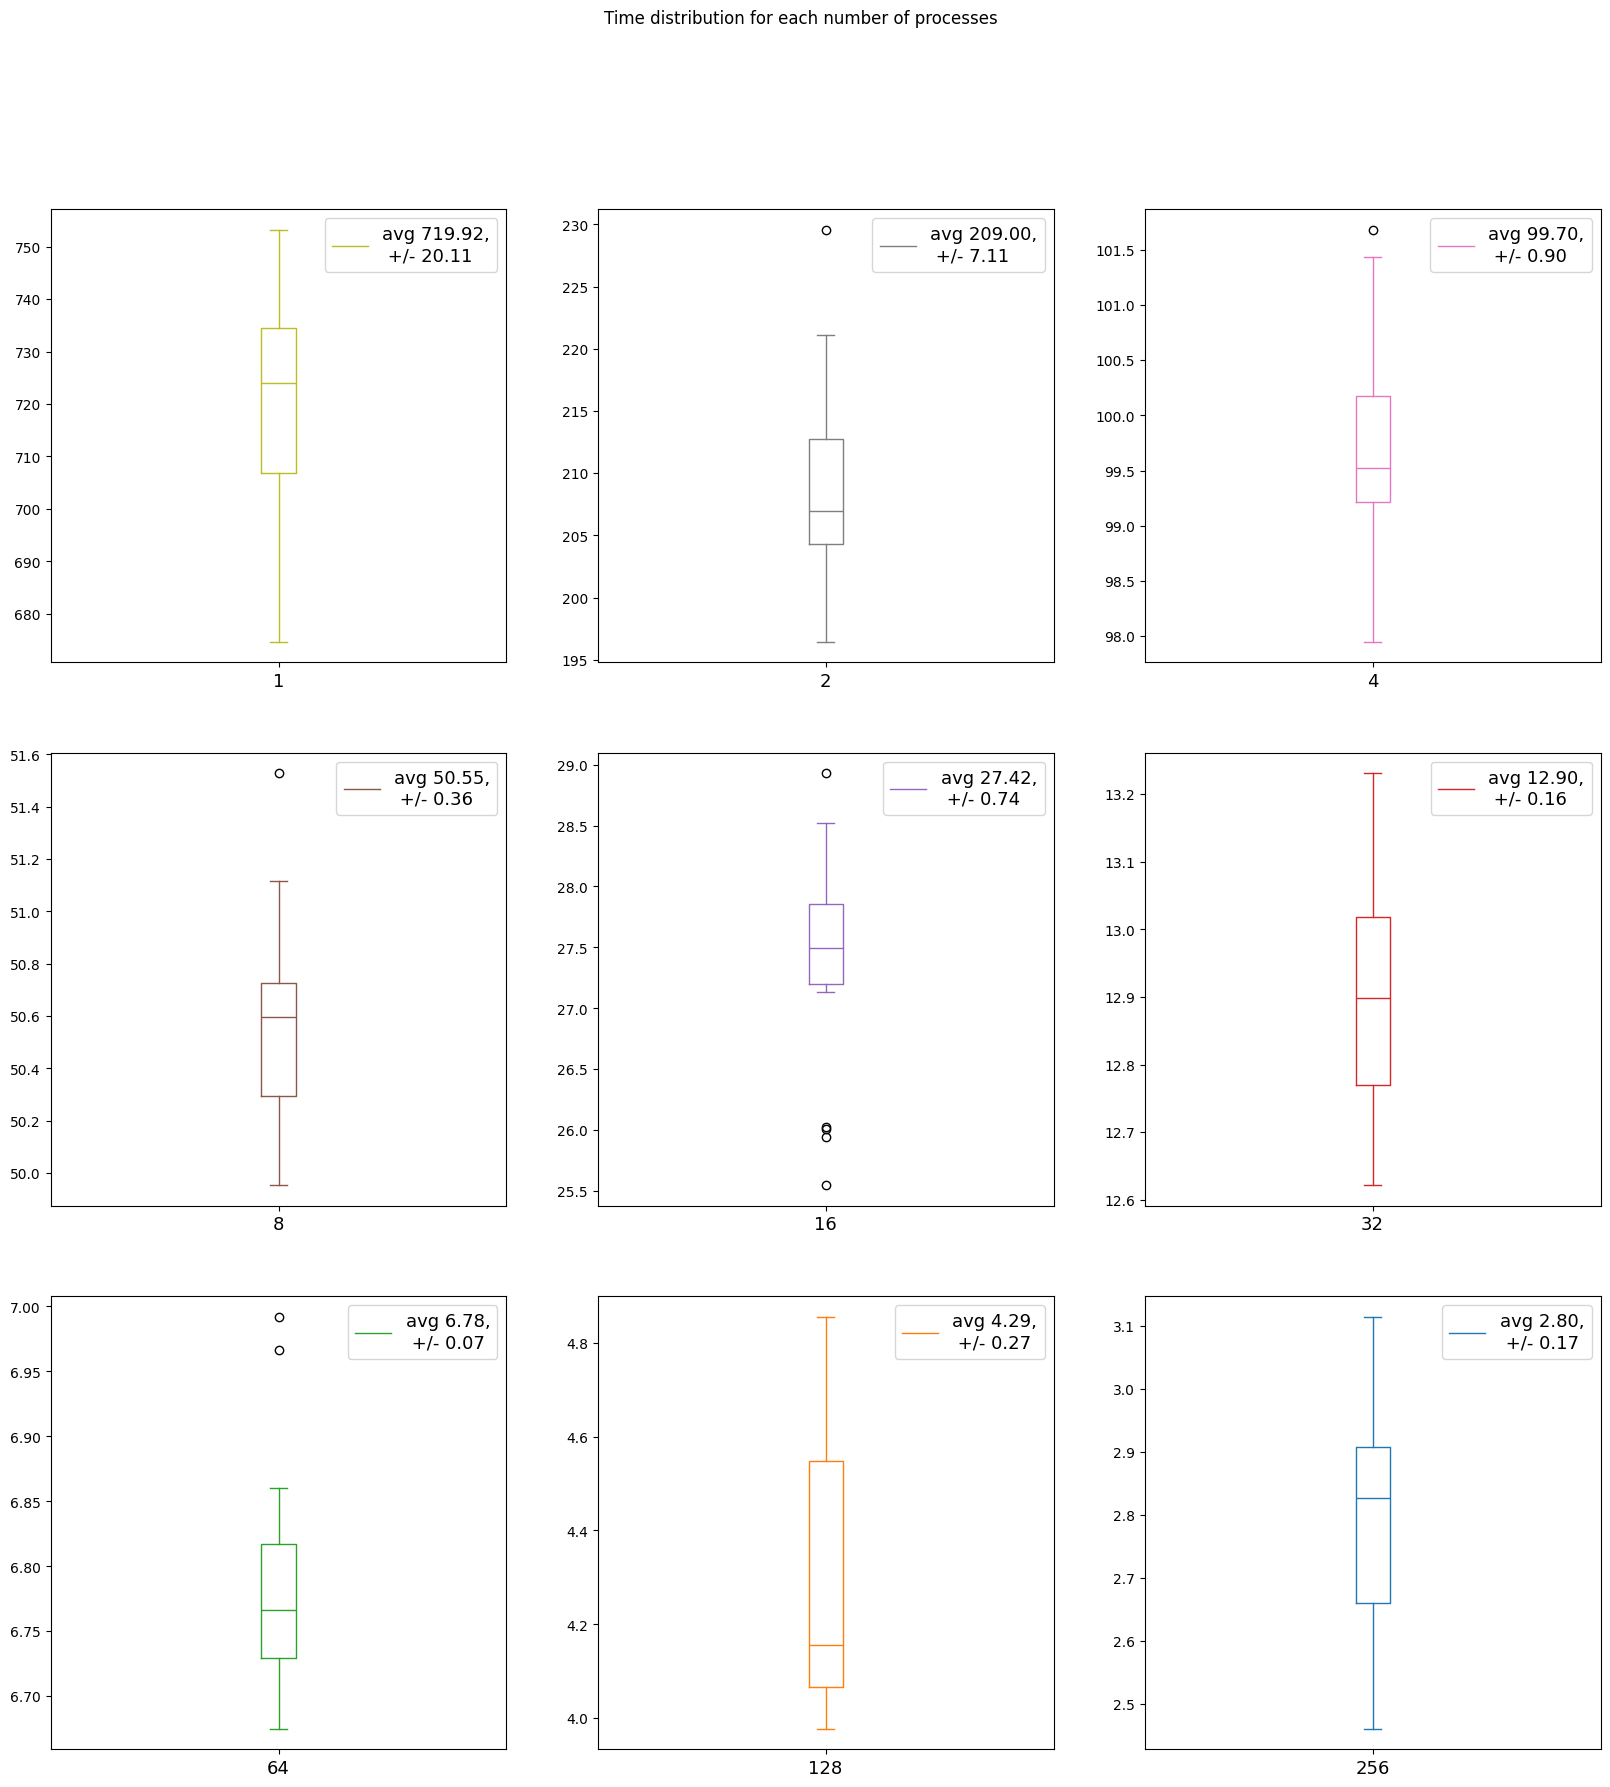

In [3]:
# For each number of processes, build a candlestick plot with the time distribution
fig, ax = plt.subplots(3,3, figsize=(20, 20))
fig.suptitle("Time distribution for each number of processes")
ax = ax.flatten()
for i, (proc, group) in enumerate(df.groupby('proc')):
    ax[i].boxplot(group['time'], 
                    positions=[i],
                    showfliers=True,
                    boxprops=dict(color=proc_colors[proc]),
                    whiskerprops=dict(color=proc_colors[proc]),
                    capprops=dict(color=proc_colors[proc]),
                    medianprops=dict(color=proc_colors[proc]))
    ax[i].set_xlim(i-1, i+1)
    ax[i].set_xticklabels([str(2**i)], fontsize=13)
    ax[i].legend([f'avg {df_grouped["time"]["mean"][proc]:.2f},\n +/- {df_grouped["time"]["std"][proc]:.2f}'], loc='upper right', fontsize=13)
    


## Section 2 - Multiprocessing Library
Python offers a built-in library called `multiprocessing` that leverages multiple CPU cores to run several processes concurrently. This package supports process spawning with an API similar to the traditional `threading` module and is useful to side step the Global Interpreter Lock.
We spawn a Pool of processes and map the function to be executed to the corresponding input chunks. Finally, the pool is closed, all the spawned threads are joined and the partial results are concatenated together to form the output. 

## Section 3 - Joblib Library
Joblib is a set of tools that provide a pipeline to achieve parallel capabilities. Several jobs are created to execute the `predict` function in parallel. The library is optimized for CPU-bound tasks and is more efficient than the multiprocessing library. The `Parallel` class is used to create a pool of processes and the `delayed` function is used to generate a delayed calls to the provided function. This library offers the best scalability on a single CPU node, as we will see in the results. Aside from multiprocessing, the other two libraries are not specifically suited to handle embarassingly parallel task, but rather to provide efficient data structures (Dask) or to exploit compiler optimizations (Numba). 

## Section 4 - Dask Library

Dask is a flexible parallel computing library for analytics that enables advanced parallelism. It provides parallel data structures which mirror those of numpy, allowing easy integration with existing code. These structures automatically partition code across multiple cores. It also features delayed execution, helpful in minimizing memory usage and computation time by delaying execution until the final result is requested. This primitive is used to create several batches that will be executed in parallel, allowing for a more efficient and versatile computation.

## Section 5 - Numba Library on CPU
Numba is a just-in-time compiler for Python that translates Python functions to optimized machine code at runtime using the industry-standard LLVM compiler library. It is designed to work with numpy data structures and user-defined functions as well as classes. In this section, we used Numba to perform code generation for the `KNNClassifierNumba` class, so that all methods of the class are compiled to non-python functions and bypass the interpreter. This can be achieved by simply adding the `@jitclass` decorator to the class definition, as well as the `@njit` decorator to the methods outside of the class. We also need to provide the specifications for the class numbers, which consist of a dictionary with the name of the attribute as the key and the type as the value. Unfortunately, numba has limited compatibility with other parallel libraries like the ones above, so we could not use it in conjunction with them.

## Run the tests
The tests to benchmark the different implementations can be run in to ways:
- interactive mode: dedicated python script to run each implementation separately, display whether the results are correct, measure the execution time and the speedup
- batch mode: slurm script to run all the implementations and gather the results in a single output file

# Install the dependencies
The following dependencies are required to run the tests:
- joblib
- dask
- numba
- numpy
- multiprocessing \
These can be installed in a virtual environment (Python3.8.6 was used for all simulations) by running the following commands:
```bash
    python3 -m venv .venv
    source .venv/bin/activate
    pip install -r requirements.txt
```
Each one of the four implementations has its own test script that can be run separately. The results are stored in the `results` folder in csv format. The `job.sh` script can be used to run the tests in batch mode, but needs to be modified with the correct path of the virtual environment where the dependencies have been installed.

In [ ]:
# interactive mode 
# change the file name to the one you want to test
%python3 knn_single_node/single_node/test_knn_joblib.py 

In [ ]:
# batch mode
%sbatch knn_single_node/job.sh

## Results
Let us plot the strong scalability of the different implementations on the same plot, featuring the number of threads on the x-axis and the execution time on the y-axis.

In [ ]:
%pip install pandas
%pip install seaborn
%pip install numpy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# an example of the simulation data is the following
df = pd.read_csv('knn_single_node/results/dask_times.csv')
df.head(5)

,Threads,Time
0,8,53.671787
1,8,51.180917
2,8,51.421624
3,8,50.419632
4,8,50.683989


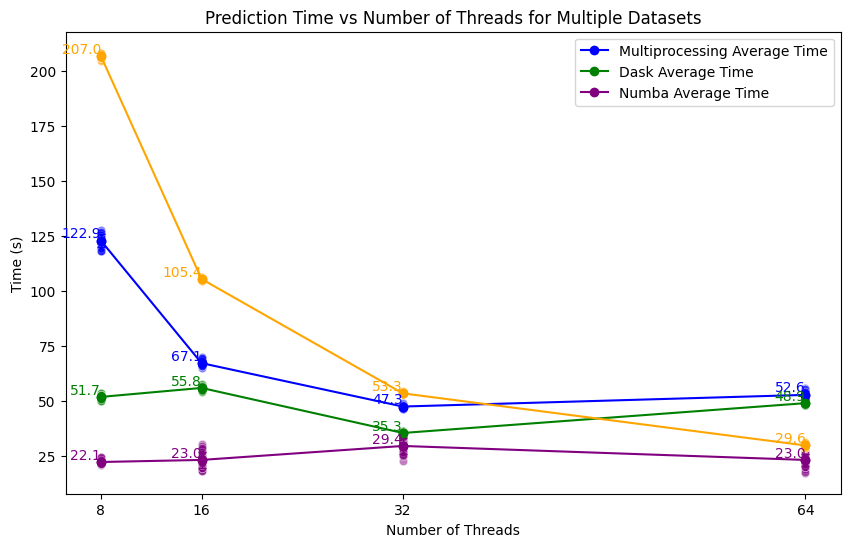

In [5]:
# List of filenames, labels and colors for the datasets
filenames = ['knn_single_node/results/mp_times.csv', 'knn_single_node/results/dask_times.csv', 'knn_single_node/results/numba_times.csv', 'knn_single_node/results/joblib_times.csv']
labels = ['Multiprocessing', 'Dask', 'Numba', 'Joblib']  
colors = ['blue', 'green', 'purple', 'orange']  
plt.figure(figsize=(10, 6)) 

for i, filename in enumerate(filenames):
    df = pd.read_csv(filename)
    # Group the data by number of threads and calculate mean and standard deviation of the execution time
    df_grouped = df.groupby('Threads').agg({'Time': ['mean', 'std']}).reset_index()
    # Rename columns for better readability
    df_grouped.columns = ['Threads', 'MeanTime', 'StdDevTime']
    # Plot data points with a scatter plot
    sns.scatterplot(data=df, x='Threads', y='Time', color=colors[i], alpha=0.5)
    # Line plot that connects the average execution time for each number of threads
    plt.plot(df_grouped['Threads'], df_grouped['MeanTime'], marker='o', color=colors[i], label=f'{labels[i]} Average Time')
    # Plot vertical error bars to represent the standard deviation at each mean point
    plt.errorbar(df_grouped['Threads'], df_grouped['MeanTime'], yerr=df_grouped['StdDevTime'], fmt='o', 
                 color=colors[i], ecolor=colors[i], elinewidth=1, capsize=3)
    # Annotate the mean values on the plot
    for j, row in df_grouped.iterrows():
        plt.text(row['Threads'], row['MeanTime'], f'{row["MeanTime"]:.1f}', ha='right', va='bottom', 
                 color=colors[i], fontsize=10)

plt.xlabel('Number of Threads')
plt.ylabel('Time (s)')
plt.title('Prediction Time vs Number of Threads for Multiple Datasets')
# Set x-axis ticks based on all unique thread counts across datasets
all_threads = pd.concat([pd.read_csv(f)['Threads'] for f in filenames]).unique()
plt.xticks(np.sort(all_threads))
plt.show()


Now let us visualize the average execution time and standard deviation of the different implementations for each test size by the means of boxplots. You can change the number of threads in the cell below to visualize the results for the value of interest. Possible values are 8,16,32,64.
FInally, we can plot the speedup of the different implementations for each test size, by dividing the execution time of the serial implementation by the execution time of the parallel implementation.

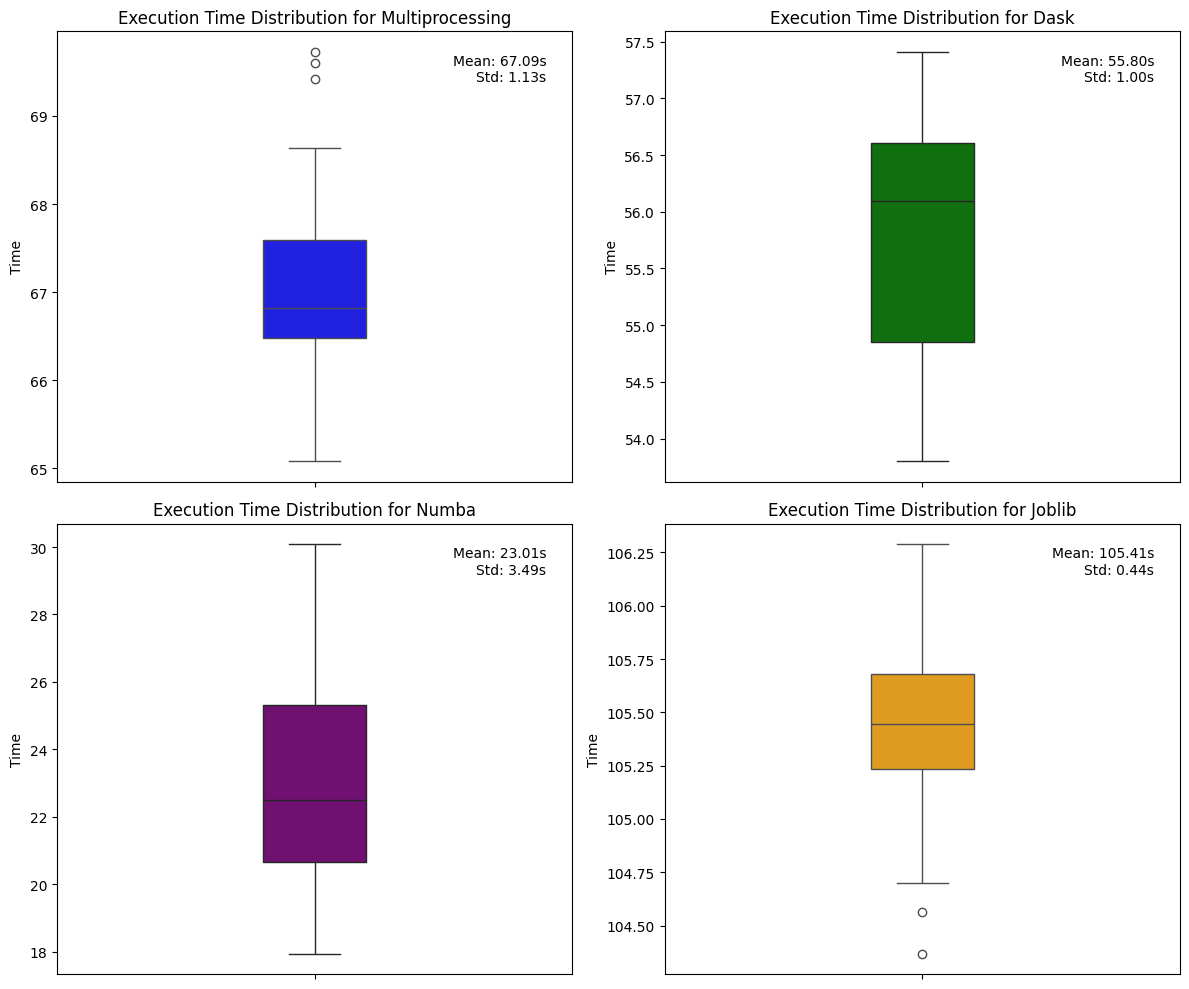

In [6]:
# Load each dataset, add a column to identify the dataset and store in a list
# CHANGE THE NUMBER OF THREADS TO THE DESIRED VALUE
num_threads = 16
dfs = []
for label, filename in zip(labels, filenames):
    df = pd.read_csv(filename)
    df_filtered = df[df['Threads'] == num_threads].copy()
    df_filtered.loc[:, 'Dataset'] = label  
    dfs.append(df_filtered)

# Concatenate all datasets into a single DataFrame
all_data = pd.concat(dfs)
# Define the number of rows and columns for subplots (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True)
# Flatten axes array for easier iteration
axes = axes.flatten()
# Define a color palette for each dataset
palette = ['blue', 'green', 'purple', 'orange'] 
# Loop over each dataset and create a box plot in its respective subplot
for i, (ax, label) in enumerate(zip(axes, labels)):
    sns.boxplot(
        data=all_data[all_data['Dataset'] == label], 
        y='Time', 
        color=palette[i], 
        width=0.2,  
        ax=ax
    )
    ax.set_title(f'Execution Time Distribution for {label}')
    ax.set_xticklabels([])  
    # Center the boxplot by removing any extra x-ticks
    ax.set_xlim(-0.5, 0.5)  
    # Annotate the mean and standard deviation values on the plot
    ax.text(0.95, 0.95, 
        f"Mean: {all_data[all_data['Dataset'] == label]['Time'].mean():.2f}s\nStd: {all_data[all_data['Dataset'] == label]['Time'].std():.2f}s", 
        ha='right', va='top', transform=ax.transAxes, fontsize=10, color='black')

# Hide any unused subplots (if fewer than 4 datasets)
for j in range(len(labels), 4):
    fig.delaxes(axes[j])
# Adjust layout for better spacing
plt.tight_layout()
plt.show()

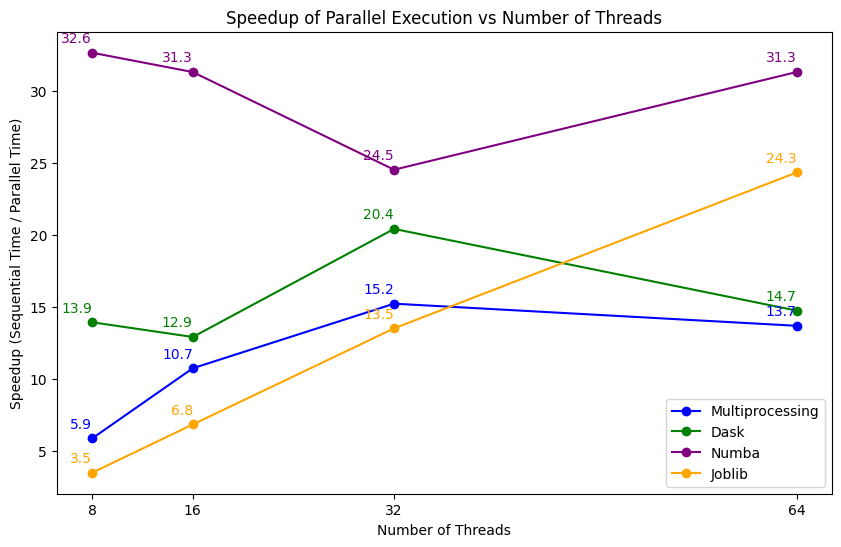

In [7]:
plt.figure(figsize=(10, 6))  

for i, filename in enumerate(filenames):
    df = pd.read_csv(filename)
    # Set the sequential execution time (assumed to be at Threads == 1)
    sequential_time = 719.92
    # Group by Threads and calculate the mean time for each thread count
    df_grouped = df.groupby('Threads').agg({'Time': 'mean'}).reset_index()
    # Calculate the speedup for each thread count
    df_grouped['Speedup'] = sequential_time / df_grouped['Time']  
    # Plot the speedup line
    plt.plot(df_grouped['Threads'], df_grouped['Speedup'], marker='o', color=colors[i], label=labels[i])
    for j, row in df_grouped.iterrows():
        plt.text(row['Threads'], row['Speedup'] + 0.5, f'{row["Speedup"]:.1f}', ha='right', va='bottom', 
                 color=colors[i], fontsize=10)

plt.xlabel('Number of Threads')
plt.ylabel('Speedup (Sequential Time / Parallel Time)')
plt.title('Speedup of Parallel Execution vs Number of Threads')
# Set x-axis ticks based on all unique thread counts across datasets
all_threads = pd.concat([pd.read_csv(f)['Threads'] for f in filenames]).unique()
plt.xticks(np.sort(all_threads))
plt.legend()
plt.show()